# Finance Project 1 – Linear Programming

### Aidan Cremins, Peyton Lewis, Mark Moreno, Joe Morris

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import gurobipy as gp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings('ignore')

# Read in Liabilities and Bonds CSVs

In [2]:
# Read in liabilities.csv
liabilities = pd.read_csv('liabilities.csv')
liabilities.head(8)

,Year,Liability
0,1,1200000
1,2,1800000
2,3,2000000
3,4,2000000
4,5,1600000
5,6,1500000
6,7,1200000
7,8,1000000


In [3]:
# Read in bonds.csv
bonds = pd.read_csv('bonds.csv')
bonds.head(13)

,Bond,Price,Coupon,StartTime,Maturity
0,1,102,5.0,0,1
1,2,100,3.0,1,2
2,3,99,3.5,0,2
3,4,101,4.0,0,2
4,5,98,2.5,0,3
5,6,98,4.0,0,4
6,7,98,2.0,2,4
7,8,104,9.0,0,5
8,9,100,6.0,0,5
9,10,101,8.0,0,6


# Function Definitions

#### Function to create dataframe of all bond inflows and outflows at each time for each bond

In [4]:
def create_df(bonds, liabilities) :
    # create dataframe with all possible combinations of bonds and liabilities
    df = pd.DataFrame(columns=['Year', 'Bond', 'Price Outflow', 'Coupon Inflow', 'FV Inflow'])
    # Loop through each bond
    for index, row in bonds.iterrows() :
        # create a row for each year
        for year in range(len(liabilities) + 1) :
            # if row is the start time, add the price outflow
            if year == row['StartTime'] :
                df.loc[len(df)] = [year, row['Bond'], -row['Price'], 0, 0]
            # if row is the maturity date, add the FV inflow and coupon inflow
            elif year == row['Maturity'] :
                df.loc[len(df)] = [year, row['Bond'], 0, row['Coupon'], 100]
            # if row is between start and maturity date, add the coupon inflow
            elif year > row['StartTime'] and year < row['Maturity'] :
                df.loc[len(df)] = [year, row['Bond'], 0, row['Coupon'], 0]
            # if row is not between start and maturity date, add 0
            else :
                df.loc[len(df)] = [year, row['Bond'], 0, 0, 0]
    return df

#### Function to find A, obj, b, sense

In [5]:
def create_parameters(liabilities, bonds, df_year) :

    # create an empty matrix for the parameters length of liabilities times length of bonds
    A = np.zeros((len(liabilities), len(bonds)))
    # create an empty array for the objective function length of bonds
    obj = np.zeros(len(bonds) )
    
    # loop through each year of the liabilities
    for index, row in df_year.iterrows() :
        # fill in obj function
        if row['Year'] == 0 :
            obj[int(row['Bond']) - 1] = row['Price Outflow'] + row['Coupon Inflow'] + row['FV Inflow']

        # add price outflow + coupon inflow + fv inflow to A matrix
        if row['Year'] > 0 :
            A[int(row['Year']) - 1][int(row['Bond'] - 1)] = row['Price Outflow'] + row['Coupon Inflow'] + row['FV Inflow']

    # create an empty array for the right hand side of the constraints
    b = np.zeros(len(liabilities))
    # fill in the right hand side of the constraints with the liabilities
    for index, row in liabilities.iterrows() :
        b[index] = row['Liability']
        
    # create an array for the direction of the constraints
    sense = np.array(['='] * len(liabilities))

    return A, obj, b, sense

#### Function to print the parameters

In [6]:
def print_parameters(A, obj, b, sense) :
    print('Coefficient Matrix (A):')
    print(A)
    print()
    print('Objective Function (obj):')
    print(obj)
    print()
    print('Right Hand Side (b):')
    print(b)
    print()
    print('Direction (sense):')
    print(sense)

#### Function to solve the problem

In [7]:
def solve_model(A, obj, b, sense) :
    finMod = gp.Model()
    finMod_x = finMod.addMVar(len(obj)) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    finMod_con = finMod.addMConstrs(A, finMod_x, sense, b) # NAME THE CONSTRAINTS!!! so we can get information about them later!
    finMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

    finMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    finMod.optimize()

    return finMod.objVal, finMod_x.x, finMod, finMod_con

#### Function to print the solution

In [8]:
def print_results(liabilities, objVal, x) :
    # print results header
    print('Results:')
    print()
    # print the total liabilities
    print('Liabilities:', '${:,.2f}'.format(liabilities['Liability'].sum()))
    # print the total value of the bonds in year 0
    print('Optimal amount spent:', '${:,.2f}'.format(objVal))
    # print the total savings (liabilities - Amount spent)
    print('Savings (Liabilities - Amount Spent):', '${:,.2f}'.format(liabilities['Liability'].sum() + objVal))
    print()
    # print the bonds and the amount of each bond in the optimal solution
    print('Optimal Solution (Amount to buy of each bond):')
    for i in range(len(x)) :
        print('\tBond {}:'.format(i + 1), '{:,.2f}'.format(x[i]))

#### Function to check if our cashflows make sense in our model (Returns dataframe of cashflows)

In [9]:
def check_table(bonds, liabilities, finMod_x) :
    # make dataframe for years 0 to year len(liabilities)
    df_results = pd.DataFrame()
    for i in range(len(liabilities) + 1) :
        df_results['Year {}'.format(i)] = 0.0

    # add a row to df_results for each bond
    for index, row in bonds.iterrows() :
        df_results.loc['Bond {}'.format(int(row['Bond']))] = 0.0

    # add rows for excess funds and liabilities
    df_results.loc['Excess Funds'] = 0.0
    df_results.loc['Liabilities'] = 0.0

    # for each bond in bonds, add the price outflow to the year it starts
    for index, row in bonds.iterrows() :
        df_results.loc['Bond {}'.format(int(row['Bond']))]['Year {}'.format(int(row['StartTime']))] = -row['Price']

    # for each bond in bonds, add the coupon inflow after start year until maturity
    for index, row in bonds.iterrows() :
        for year in range(int(row['StartTime']) + 1, int(row['Maturity']) + 1) :
            df_results.loc['Bond {}'.format(int(row['Bond']))]['Year {}'.format(year)] = row['Coupon']

    # for each bond in bonds, add the fv inflow to the maturity year
    for index, row in bonds.iterrows() :
        df_results.loc['Bond {}'.format(int(row['Bond']))]['Year {}'.format(int(row['Maturity']))] += 100

    #multiple the bond values by the finMod_x.x values
    for index, row in df_results.iterrows() :
        if index[0:4] == 'Bond' :
            df_results.loc[index] = df_results.loc[index] * finMod_x[int(index[5:]) - 1]

    # add liabilities to df_results
    for index, row in liabilities.iterrows() :
        df_results.loc['Liabilities']['Year {}'.format(index + 1)] = -row['Liability']

    # iterate through columns of df_results and add the values to the excess funds column
    for index, row in df_results.iterrows() :
        if index[0:4] == 'Bond' or index == 'Liabilities' :
            df_results.loc['Excess Funds'] += df_results.loc[index]

    # format df_results to 2 decimal places
    pd.options.display.float_format = '{:.2f}'.format

    # make df_results 0.0 if value is between -0.01 and 0.01
    for index, row in df_results.iterrows() :
        for col in df_results.columns :
            if df_results.loc[index][col] > -0.01 and df_results.loc[index][col] < 0.01 :
                df_results.loc[index][col] = 0.0

    return df_results

#### Plot to check if our liabilities are matched with our net inflows

In [10]:
def plot_inflows_vs_liabilities(df) :
    # create a df without year 0
    df_no_year_0 = df.drop('Year 0', axis=1)
    # drop the none bond rows figure size 15 time 7 and plot 
    df_no_year_0.drop(['Liabilities', 'Excess Funds']).sum().plot(kind='bar', color='#238823', label='Net Inflows (Inflows - Outflows)', figsize=(15,7))
    # plot the liabilities and the inflows for each year
    df_no_year_0.loc['Liabilities'].plot(kind='bar', color='#D2222D', label='Liabilities')
    
    # Format the plot
    plt.title('Net Inflows vs Liabilities')
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Dollars', fontsize=18)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
    # add a line for the value of excess funds
    plt.axhline(y=0, color='#006FEF', linestyle='-', label='Excess Funds', linewidth=5)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(bbox_to_anchor=(0, -.25), loc=2, fontsize=18)
    plt.title('Net Inflows vs. Liabilities', fontweight="bold", fontsize=18)
    plt.show()

#### Function to find yield to maturity for each bond

In [11]:
def ytm(bonds) :
    ytms = []
    # create a list of cash flows for each bond by year
    for index, row in bonds.iterrows():
        cf = [0,0,0,0,0,0,0,0,0]
        cf[int(row['StartTime'])] = -row['Price']
        start = row['StartTime']
        for i in range(int(row['StartTime']) + 1, int(row['Maturity'])):
            cf[i] = row['Coupon']
        cf[int(row['Maturity'])] = (100+row['Coupon'])
        # use irr to calculate the ytm
        ytm = npf.irr(cf)
        # add the ytm to the list
        ytms.append(ytm)
    # add the ytm list to the bonds dataframe
    bonds['YTM'] = ytms
    bonds['YTM'] = bonds['YTM'].map('{:.2%}'.format)
    return bonds

# Solve Problem (Bonds and Liabilities Given)

#### Create dataframe of all bond inflows and outflows at each time per bond

In [12]:
df = create_df(bonds, liabilities)
df.head()

,Year,Bond,Price Outflow,Coupon Inflow,FV Inflow
0,0.0,1.0,-102.0,0.0,0.0
1,1.0,1.0,0.0,5.0,100.0
2,2.0,1.0,0.0,0.0,0.0
3,3.0,1.0,0.0,0.0,0.0
4,4.0,1.0,0.0,0.0,0.0


#### Find Coefficient Matrix (A), Objective Function (obj), Right Hand Side (b), Direction (sense)

In [13]:
A, obj, b, sense = create_parameters(liabilities, bonds, df)

In [14]:
print_parameters(A, obj, b, sense)

Coefficient Matrix (A):
[[ 105.  -100.     3.5    4.     2.5    4.     0.     9.     6.     8.
     9.     7.     0. ]
 [   0.   103.   103.5  104.     2.5    4.   -98.     9.     6.     8.
     9.     7.     0. ]
 [   0.     0.     0.     0.   102.5    4.     2.     9.     6.     8.
     9.     7.   -91. ]
 [   0.     0.     0.     0.     0.   104.   102.     9.     6.     8.
     9.     7.     3. ]
 [   0.     0.     0.     0.     0.     0.     0.   109.   106.     8.
     9.     7.     3. ]
 [   0.     0.     0.     0.     0.     0.     0.     0.     0.   108.
     9.     7.     3. ]
 [   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   109.     7.     3. ]
 [   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.   107.   103. ]]

Objective Function (obj):
[-102.    0.  -99. -101.  -98.  -98.    0. -104. -100. -101. -102.  -94.
    0.]

Right Hand Side (b):
[1200000. 1800000. 2000000. 2000000. 1600000. 1500000. 1200000. 1000000.]

Direction 

## Solve the problem: Print the Objective Value and Optimal Solution

In [15]:
objVal, x, model, model_con = solve_model(A, obj, b, sense)
print('Optimal Objective Value:', objVal)
print('Optimal Solution:', x)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Optimal Objective Value: -9447500.757413374
Optimal Solution: [ 6522.49172708     0.         12848.61631343     0.
 15298.31788441 15680.77583152     0.         12308.00686478
     0.         12415.72748261 10408.98568121  9345.79439252
     0.        ]


### Results showing our total liabilities, optimal amount spent, savings, and optimal solution

In [16]:
print_results(liabilities, objVal, x)

Results:

Liabilities: $12,300,000.00
Optimal amount spent: $-9,447,500.76
Savings (Liabilities - Amount Spent): $2,852,499.24

Optimal Solution (Amount to buy of each bond):
	Bond 1: 6,522.49
	Bond 2: 0.00
	Bond 3: 12,848.62
	Bond 4: 0.00
	Bond 5: 15,298.32
	Bond 6: 15,680.78
	Bond 7: 0.00
	Bond 8: 12,308.01
	Bond 9: 0.00
	Bond 10: 12,415.73
	Bond 11: 10,408.99
	Bond 12: 9,345.79
	Bond 13: 0.00


#### Check if our solution makes sense (Matches our liabilities)

In [17]:
A @ x

array([1200000., 1800000., 2000000., 2000000., 1600000., 1500000.,
       1200000., 1000000.])

#### Create table of cashflows for each bond to check if our solution meets our constraints

In [18]:
df_results = check_table(bonds, liabilities, x)

# Add dollar signs to df_results
df_results_format = df_results.applymap('${:,.2f}'.format)
df_results_format.head(15)

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6,Year 7,Year 8
Bond 1,"$-665,294.16","$684,861.63",$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 2,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 3,"$-1,272,013.02","$44,970.16","$1,329,831.79",$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 4,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 5,"$-1,499,235.15","$38,245.79","$38,245.79","$1,568,077.58",$0.00,$0.00,$0.00,$0.00,$0.00
Bond 6,"$-1,536,716.03","$62,723.10","$62,723.10","$62,723.10","$1,630,800.69",$0.00,$0.00,$0.00,$0.00
Bond 7,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 8,"$-1,280,032.71","$110,772.06","$110,772.06","$110,772.06","$110,772.06","$1,341,572.75",$0.00,$0.00,$0.00
Bond 9,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 10,"$-1,253,988.48","$99,325.82","$99,325.82","$99,325.82","$99,325.82","$99,325.82","$1,340,898.57",$0.00,$0.00


#### Plot to check if our liabilities are matched with our net inflows

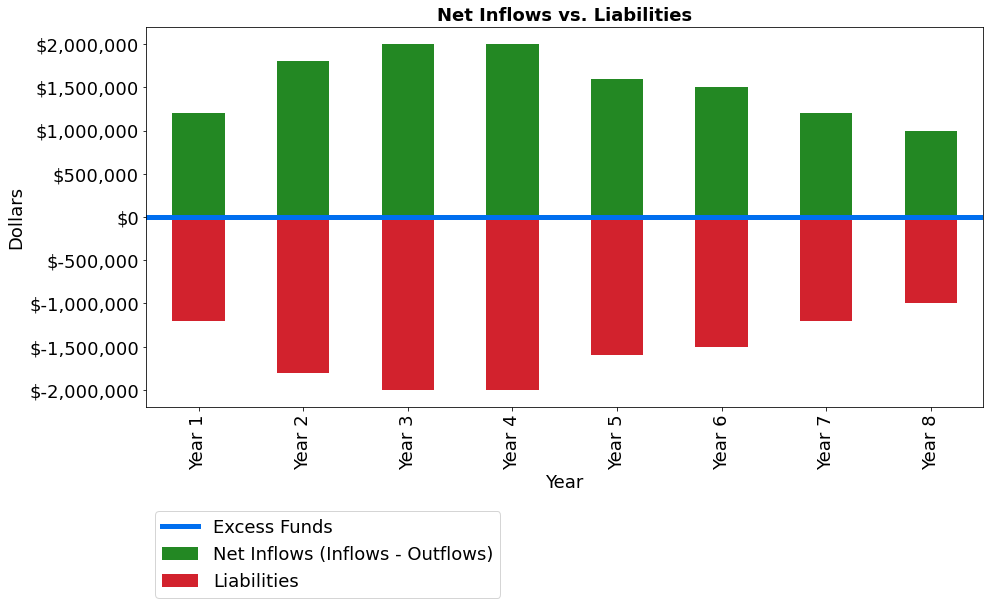

In [19]:
plot_inflows_vs_liabilities(df_results)

## Sensitivity Analysis

In [20]:
# get the lower and upper bounds where the shadow prices are valid
low = [con.SARHSlow for con in model_con]
high = [con.SARHSup for con in model_con]
# get the shadow prices
pi = [con.pi for con in model_con]

# create a dataframe of the shadow prices, lower bounds, and upper bounds
df_con = pd.DataFrame({'Low': low, 'High': high, 'Pi': pi, 'Actual': A @ x}, index=['Year {}'.format(i + 1) for i in range(len(low))])

# create a range column, upper bound - lower bound
df_con['Range'] = df_con['High'] - df_con['Low']
# rename the columns for clarity
df_con.rename(columns={'Pi': 'Shadow Price', 'Actual':'Liability'}, inplace=True)

# format the dataframe by changing python mathmatical errors to 0.0
for index, row in df_con.iterrows() :
    for col in df_con.columns :
        if df_con.loc[index][col] > -0.01 and df_con.loc[index][col] < 0.01 :
            df_con.loc[index][col] = 0.0

# format the dataframe to 2 decimal places and add dollar signs
df_con_format = df_con.applymap('${:,.2f}'.format)

df_con_format.head(18)

,Low,High,Shadow Price,Liability,Range
Year 1,"$515,138.37",$inf,$-0.97,"$1,200,000.00",$inf
Year 2,"$470,168.21","$22,052,336.81",$-0.92,"$1,800,000.00","$21,582,168.60"
Year 3,"$431,922.42","$31,062,103.33",$-0.91,"$2,000,000.00","$30,630,180.91"
Year 4,"$369,199.31","$20,890,367.16",$-0.83,"$2,000,000.00","$20,521,167.85"
Year 5,"$258,427.25","$10,751,333.43",$-0.65,"$1,600,000.00","$10,492,906.17"
Year 6,"$159,101.43","$12,618,870.11",$-0.62,"$1,500,000.00","$12,459,768.68"
Year 7,"$65,420.56","$11,972,949.71",$-0.53,"$1,200,000.00","$11,907,529.15"
Year 8,$0.00,"$15,820,500.81",$-0.52,"$1,000,000.00","$15,820,500.81"


#### Find yield to maturity for each bond

In [21]:
ytm(bonds).head(16)

,Bond,Price,Coupon,StartTime,Maturity,YTM
0,1,102,5.00,0,1,2.94%
1,2,100,3.00,1,2,3.00%
2,3,99,3.50,0,2,4.03%
3,4,101,4.00,0,2,3.47%
4,5,98,2.50,0,3,3.21%
5,6,98,4.00,0,4,4.56%
6,7,98,2.00,2,4,3.05%
7,8,104,9.00,0,5,8.00%
8,9,100,6.00,0,5,6.00%
9,10,101,8.00,0,6,7.79%


# Solve Problem (Real Data Analysis)

### Data was fetched as of  10-07-2022

### Create a dataframe of all bonds for August until mid September (from WSJ data)

#### Run cell below if submission allowed for CSV uploads

In [22]:
# real_bonds = pd.read_csv('real_bonds.csv')

# pd.options.display.float_format = '{:.4f}'.format

# real_bonds.head()

#### Hard code in real bond values because submission does not allow for CSV uploads

In [23]:
bond_values = [[1, 0.125, 96.204, 1, 0.0, '2023-08-15'],
[1, 2.5, 98.184, 2, 0.0, '2023-08-15'],
[1, 6.25, 101.25399999999999, 3, 0.0, '2023-08-15'],
[1, 0.125, 96.14, 4, 0.0, '2023-08-31'],
[1, 1.375, 97.154, 5, 0.0, '2023-08-31'],
[1, 2.75, 98.25200000000001, 6, 0.0, '2023-08-31'],
[1, 0.125, 96.09, 7, 0.0, '2023-09-15'],
[2, 0.375, 93.066, 8, 0.0, '2024-08-15'],
[2, 2.375, 96.24, 9, 0.0, '2024-08-15'],
[2, 1.25, 94.22399999999999, 10, 0.0, '2024-08-31'],
[2, 1.875, 95.262, 11, 0.0, '2024-08-31'],
[2, 3.25, 98.1, 12, 0.0, '2024-08-31'],
[2, 0.375, 92.31, 13, 0.0, '2024-09-15'],
[3, 2.0, 94.056, 14, 0.0, '2025-08-15'],
[3, 3.125, 97.054, 15, 0.0, '2025-08-15'],
[3, 6.875, 107.05, 16, 0.0, '2025-08-15'],
[3, 0.25, 89.11, 17, 0.0, '2025-08-31'],
[3, 2.75, 96.04, 18, 0.0, '2025-08-31'],
[3, 3.5, 98.054, 19, 0.0, '2025-09-15'],
[4, 1.5, 90.25, 20, 0.0, '2026-08-15'],
[4, 6.75, 109.176, 21, 0.0, '2026-08-15'],
[4, 0.75, 88.014, 22, 0.0, '2026-08-31'],
[4, 1.375, 90.11200000000001, 23, 0.0, '2026-08-31'],
[5, 2.25, 92.11399999999999, 24, 0.0, '2027-08-15'],
[5, 6.375, 110.09, 25, 0.0, '2027-08-15'],
[5, 0.5, 84.206, 26, 0.0, '2027-08-31'],
[5, 3.125, 96.104, 27, 0.0, '2027-08-31'],
[6, 2.875, 94.08200000000001, 28, 0.0, '2028-08-15'],
[6, 5.5, 107.27, 29, 0.0, '2028-08-15'],
[6, 1.125, 85.03399999999999, 30, 0.0, '2028-08-31'],
[7, 1.625, 86.23, 31, 0.0, '2029-08-15'],
[7, 6.125, 113.1, 32, 0.0, '2029-08-15'],
[7, 3.125, 95.11399999999999, 33, 0.0, '2029-08-31'],
[8, 0.625, 78.222, 34, 0.0, '2030-08-15']]

real_bonds = pd.DataFrame(bond_values, columns=['Maturity', 'Coupon', 'Price', 'Bond', 'StartTime', 'Maturity_Date'])

pd.options.display.float_format = '{:.4f}'.format

real_bonds.head()

,Maturity,Coupon,Price,Bond,StartTime,Maturity_Date
0,1,0.1250,96.2040,1,0.0000,2023-08-15
1,1,2.5000,98.1840,2,0.0000,2023-08-15
2,1,6.2500,101.2540,3,0.0000,2023-08-15
3,1,0.1250,96.1400,4,0.0000,2023-08-31
4,1,1.3750,97.1540,5,0.0000,2023-08-31


#### Create a dataframe with all the inflows and outflows for each year per bond

In [24]:
df_real = create_df(real_bonds, liabilities)
df_real.head()

,Year,Bond,Price Outflow,Coupon Inflow,FV Inflow
0,0.0000,1.0000,-96.2040,0.0000,0.0000
1,1.0000,1.0000,0.0000,0.1250,100.0000
2,2.0000,1.0000,0.0000,0.0000,0.0000
3,3.0000,1.0000,0.0000,0.0000,0.0000
4,4.0000,1.0000,0.0000,0.0000,0.0000


#### Find Coefficient Matrix (A_real), Objective Function (obj_real), Right Hand Side (b_real), Direction (sense_real)

In [25]:
A_real, obj_real, b_real, sense_real = create_parameters(liabilities, real_bonds, df_real)

In [26]:
print_parameters(A_real, obj_real, b_real, sense_real)

Coefficient Matrix (A):
[[100.125 102.5   106.25  100.125 101.375 102.75  100.125   0.375   2.375
    1.25    1.875   3.25    0.375   2.      3.125   6.875   0.25    2.75
    3.5     1.5     6.75    0.75    1.375   2.25    6.375   0.5     3.125
    2.875   5.5     1.125   1.625   6.125   3.125   0.625]
 [  0.      0.      0.      0.      0.      0.      0.    100.375 102.375
  101.25  101.875 103.25  100.375   2.      3.125   6.875   0.25    2.75
    3.5     1.5     6.75    0.75    1.375   2.25    6.375   0.5     3.125
    2.875   5.5     1.125   1.625   6.125   3.125   0.625]
 [  0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.    102.    103.125 106.875 100.25  102.75
  103.5     1.5     6.75    0.75    1.375   2.25    6.375   0.5     3.125
    2.875   5.5     1.125   1.625   6.125   3.125   0.625]
 [  0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      

## Solve the problem: Print the Objective Value and Optimal Solution

In [27]:
objVal_real, x_real, model_real, model_con_real = solve_model(A_real, obj_real, b_real, sense_real)
print('Optimal Objective Value:', objVal_real)
print('Optimal Solution:', x_real)

Optimal Objective Value: -10400629.420478132
Optimal Solution: [    0.             0.          7974.44498052     0.
     0.             0.             0.             0.
     0.             0.             0.             0.
 14472.8477918      0.             0.         16527.12097102
     0.             0.             0.         17663.36053778
     0.             0.             0.             0.
 13928.31094584     0.             0.             0.
 13816.24076864     0.             0.             0.
 11576.13401092  9937.88819876]


### Results showing our total liabilities, optimal amount spent, savings, and optimal solution for real data

In [28]:
print_results(liabilities, objVal_real, x_real)

Results:

Liabilities: $12,300,000.00
Optimal amount spent: $-10,400,629.42
Savings (Liabilities - Amount Spent): $1,899,370.58

Optimal Solution (Amount to buy of each bond):
	Bond 1: 0.00
	Bond 2: 0.00
	Bond 3: 7,974.44
	Bond 4: 0.00
	Bond 5: 0.00
	Bond 6: 0.00
	Bond 7: 0.00
	Bond 8: 0.00
	Bond 9: 0.00
	Bond 10: 0.00
	Bond 11: 0.00
	Bond 12: 0.00
	Bond 13: 14,472.85
	Bond 14: 0.00
	Bond 15: 0.00
	Bond 16: 16,527.12
	Bond 17: 0.00
	Bond 18: 0.00
	Bond 19: 0.00
	Bond 20: 17,663.36
	Bond 21: 0.00
	Bond 22: 0.00
	Bond 23: 0.00
	Bond 24: 0.00
	Bond 25: 13,928.31
	Bond 26: 0.00
	Bond 27: 0.00
	Bond 28: 0.00
	Bond 29: 13,816.24
	Bond 30: 0.00
	Bond 31: 0.00
	Bond 32: 0.00
	Bond 33: 11,576.13
	Bond 34: 9,937.89


#### Check if our solution makes sense (Matches our liabilities)

In [29]:
A_real @ x_real

array([1200000., 1800000., 2000000., 2000000., 1600000., 1500000.,
       1200000., 1000000.])

#### Create table of cashflows for each bond to check if our solution meets our constraints

In [30]:
df_results_real = check_table(real_bonds, liabilities, x_real)

# Add dollar signs to df_results
df_results_real_format = df_results_real.applymap('${:,.2f}'.format)
df_results_real_format.head(37)

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6,Year 7,Year 8
Bond 1,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 2,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 3,"$-807,444.45","$847,284.78",$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 4,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 5,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 6,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 7,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 8,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 9,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
Bond 10,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00


#### Plot to check if our liabilities are matched with our net inflows

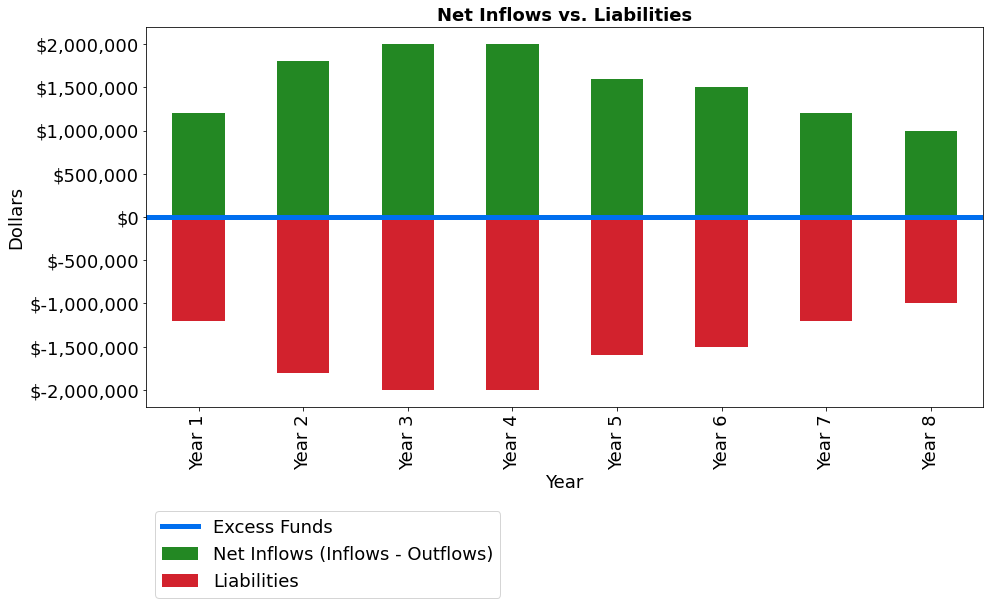

In [31]:
plot_inflows_vs_liabilities(df_results_real)

#### Yield to maturity for each bond

In [32]:
ytms = ytm(real_bonds)
ytms.head(16)

,Maturity,Coupon,Price,Bond,StartTime,Maturity_Date,YTM
0,1,0.12,96.20,1,0.00,2023-08-15,4.08%
1,1,2.50,98.18,2,0.00,2023-08-15,4.40%
2,1,6.25,101.25,3,0.00,2023-08-15,4.93%
3,1,0.12,96.14,4,0.00,2023-08-31,4.14%
4,1,1.38,97.15,5,0.00,2023-08-31,4.34%
5,1,2.75,98.25,6,0.00,2023-08-31,4.58%
6,1,0.12,96.09,7,0.00,2023-09-15,4.20%
7,2,0.38,93.07,8,0.00,2024-08-15,4.05%
8,2,2.38,96.24,9,0.00,2024-08-15,4.38%
9,2,1.25,94.22,10,0.00,2024-08-31,4.33%


#### Plot of yield to maturity by number of bonds in each maturity year, colored by which bond was selected in our optimization

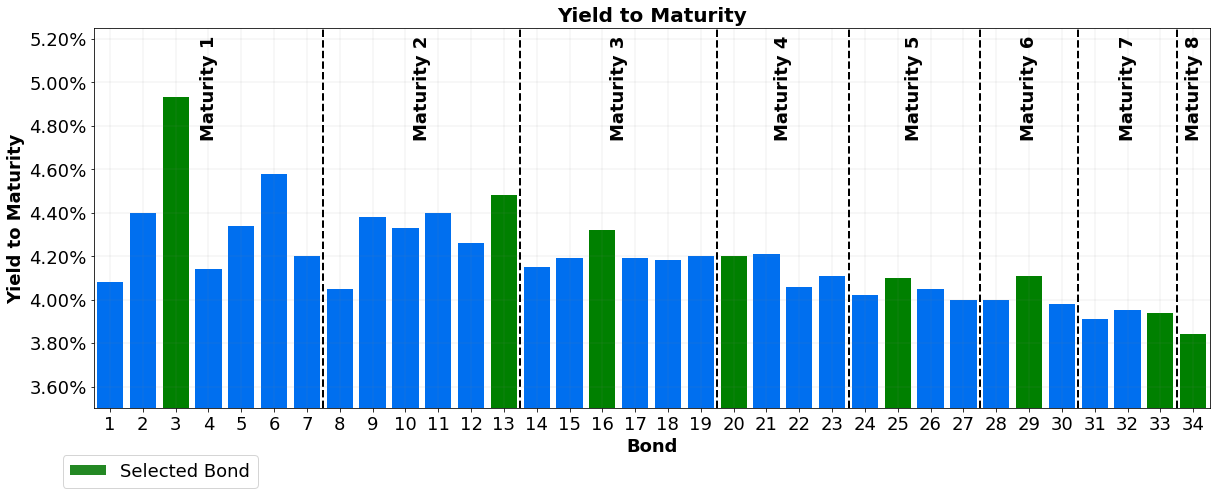

In [33]:
# list of bonds that are being used
x_real_index = [i+1 for i, x in enumerate(x_real) if x != 0]

# find list of changes in maturity between bonds (.5 added for mid point lines)
maturities = ytms['Maturity'].astype(int)
maturity_index = [i + 1.5 for i in range(len(maturities)-1) if maturities[i] != maturities[i+1]]
maturity_index = maturity_index + [len(maturities)]

# change ytm column to float and bond to int
ytm_col = ytms['YTM'].astype(str).str.replace('%', '').astype(float)
ytm_bonds = ytms['Bond'].astype(int)

# Start Plotting
plt.figure(figsize=(20,7))
plt.bar(ytm_bonds, ytm_col, color='#006FEF')
plt.xticks(np.arange(1, 35, 1))
plt.xlim(0.5, 34.5)

# add vertical line at each maturity change
for i in maturity_index:
    if i == maturity_index[-1]:
        continue
    plt.axvline(x=i, color='black', linestyle='--', linewidth=2)

# label each section creaeted by vertical lines
for i in range(len(maturity_index)):
    if i == 0:
        plt.text(maturity_index[i]/2, 4.75, 'Maturity {}'.format(i+1), fontweight="bold", rotation=90, fontsize=18)
    elif i == len(maturity_index)-1:
        plt.text((maturity_index[i-1] + maturity_index[i])/2, 4.75, 'Maturity {}'.format(i+1), fontweight="bold", rotation=90, fontsize=18)
    else:
        plt.text((maturity_index[i]+maturity_index[i-1])/2, 4.75, 'Maturity {}'.format(i+1), fontweight="bold", horizontalalignment='center', rotation=90, fontsize=18)

# color green each bar in x_real_index
for i in x_real_index:
    plt.bar(i, ytm_col[i-1], color='green')

# legend to make only one label per color 
legend = plt.legend(['Selected Bond'], bbox_to_anchor=(0.155, -0.1), ncol=2, fontsize=18)
legend.legendHandles[0].set_color('#238823')

# change legend line to solid
for i in range(len(legend.legendHandles)):
    legend.legendHandles[i].set_linewidth(10)

# format chart
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(100, decimals=2))
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Yield to Maturity', fontweight="bold", fontsize=20)
plt.xlabel('Bond', fontsize=18)
plt.ylabel('Yield to Maturity', fontsize=18)
plt.ylim(3.5, 5.25)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontweight('bold')
# add grid lines to background
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.show()

## Sensitivity Analysis for real data

In [34]:
# get the lower and upper bounds of the shadow prices
low_real = [con.SARHSlow for con in model_con_real]
high_real = [con.SARHSup for con in model_con_real]
# get the shadow prices
pi_real = [con.pi for con in model_con_real]

# create a dataframe of the shadow prices, lower bounds, and upper bounds
df_con_real = pd.DataFrame({'Low': low_real, 'High': high_real, 'Pi': pi_real, 'Actual': A_real @ x_real}, index=['Year {}'.format(i + 1) for i in range(len(low_real))])

# create range column, which is upper bound - lower bound
df_con_real['Range'] = df_con_real['High'] - df_con_real['Low']
# rename the columns for clarity
df_con_real.rename(columns={'Pi': 'Shadow Price', 'Actual':'Liability'}, inplace=True)

# format the dataframe by changing python mathmatical errors to 0.0
for index, row in df_con_real.iterrows() :
    for col in df_con_real.columns :
        if df_con_real.loc[index][col] > -0.01 and df_con_real.loc[index][col] < 0.01 :
            df_con_real.loc[index][col] = 0.0

# format the dataframe to 2 decimal places and add dollar signs
df_con_real_format = df_con_real.applymap('${:,.2f}'.format)

df_con_real_format.head(18)

,Low,High,Shadow Price,Liability,Range
Year 1,"$352,715.22",$inf,$-0.95,"$1,200,000.00",$inf
Year 2,"$347,287.90","$228,589,892.56",$-0.92,"$1,800,000.00","$228,242,604.66"
Year 3,"$233,663.95","$15,220,819.87",$-0.88,"$2,000,000.00","$14,987,155.93"
Year 4,"$207,168.91","$63,504,355.78",$-0.85,"$2,000,000.00","$63,297,186.88"
Year 5,"$118,375.92","$16,994,178.46",$-0.82,"$1,600,000.00","$16,875,802.54"
Year 6,"$42,386.60","$20,324,631.19",$-0.79,"$1,500,000.00","$20,282,244.59"
Year 7,"$6,211.18","$35,366,705.60",$-0.76,"$1,200,000.00","$35,360,494.42"
Year 8,$0.00,"$172,901,237.56",$-0.74,"$1,000,000.00","$172,901,237.56"
